**Загрузка библиотек и настройка визуализации**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
import time

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
df = pd.read_csv('Life Expectancy Data.csv')

print("=== ИНФОРМАЦИЯ О ДАТАСЕТЕ ===")
print(f"Размер датасета: {df.shape}")
print(f"Количество стран: {df['Country'].nunique()}")
print(f"Годы охвата: от {df['Year'].min()} до {df['Year'].max()}")
print("\nСтолбцы датасета:")
print(df.columns.tolist())

=== ИНФОРМАЦИЯ О ДАТАСЕТЕ ===
Размер датасета: (2938, 22)
Количество стран: 193
Годы охвата: от 2000 до 2015

Столбцы датасета:
['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure', 'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population', ' thinness  1-19 years', ' thinness 5-9 years', 'Income composition of resources', 'Schooling']


**Предварительный анализ и очистка данных**

In [3]:
print("=== ИНФОРМАЦИЯ О ТИПАХ ДАННЫХ И ПРОПУСКАХ ===")
df_info = pd.DataFrame({
    'Тип': df.dtypes,
    'Пропуски': df.isnull().sum(),
    '% Пропусков': (df.isnull().sum() / len(df) * 100).round(2)
})
print(df_info)

=== ИНФОРМАЦИЯ О ТИПАХ ДАННЫХ И ПРОПУСКАХ ===
                                     Тип  Пропуски  % Пропусков
Country                           object         0         0.00
Year                               int64         0         0.00
Status                            object         0         0.00
Life expectancy                  float64        10         0.34
Adult Mortality                  float64        10         0.34
infant deaths                      int64         0         0.00
Alcohol                          float64       194         6.60
percentage expenditure           float64         0         0.00
Hepatitis B                      float64       553        18.82
Measles                            int64         0         0.00
 BMI                             float64        34         1.16
under-five deaths                  int64         0         0.00
Polio                            float64        19         0.65
Total expenditure                float64       226        

In [4]:
print("=== ПЕРВЫЕ 5 СТРОК ДАТАСЕТА ===")
display(df.head())

=== ПЕРВЫЕ 5 СТРОК ДАТАСЕТА ===


,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [5]:
print("=== ОБРАБОТКА ПРОПУЩЕННЫХ ЗНАЧЕНИЙ ===")

df_clean = df.copy()

# Заполняем пустые значения медианными
numerical_cols = df_clean.select_dtypes(include=[np.number]).columns
for col in numerical_cols:
    if col != 'Life expectancy ':
        df_clean[col].fillna(df_clean[col].median(), inplace=True)

# Очищаем строки где продолжительность жизни имеет пустые значения
df_clean = df_clean.dropna(subset=['Life expectancy '])

print(f"Размер датасета после очистки: {df_clean.shape}")
print(f"Осталось пропусков: {df_clean.isnull().sum().sum()}")

=== ОБРАБОТКА ПРОПУЩЕННЫХ ЗНАЧЕНИЙ ===
Размер датасета после очистки: (2928, 22)
Осталось пропусков: 0


**Преобразование атрибутов и визуализация тенденций**

In [6]:
# ПРЕОБРАЗОВАНИЕ КАТЕГОРИАЛЬНЫХ ПЕРЕМЕННЫХ (0 - Developing, 1 - Developed)
df_clean['Status_numeric'] = df_clean['Status'].map({'Developing': 0, 'Developed': 1})

print("=== ПРЕОБРАЗОВАНИЕ КАТЕГОРИАЛЬНЫХ ПЕРЕМЕННЫХ ===")
print(f"Разбивка по статусу развития:")
print(df_clean['Status'].value_counts())

=== ПРЕОБРАЗОВАНИЕ КАТЕГОРИАЛЬНЫХ ПЕРЕМЕННЫХ ===
Разбивка по статусу развития:
Status
Developing    2416
Developed      512
Name: count, dtype: int64


**Визуализация 1: Глобальные тенденции продолжительности жизни**

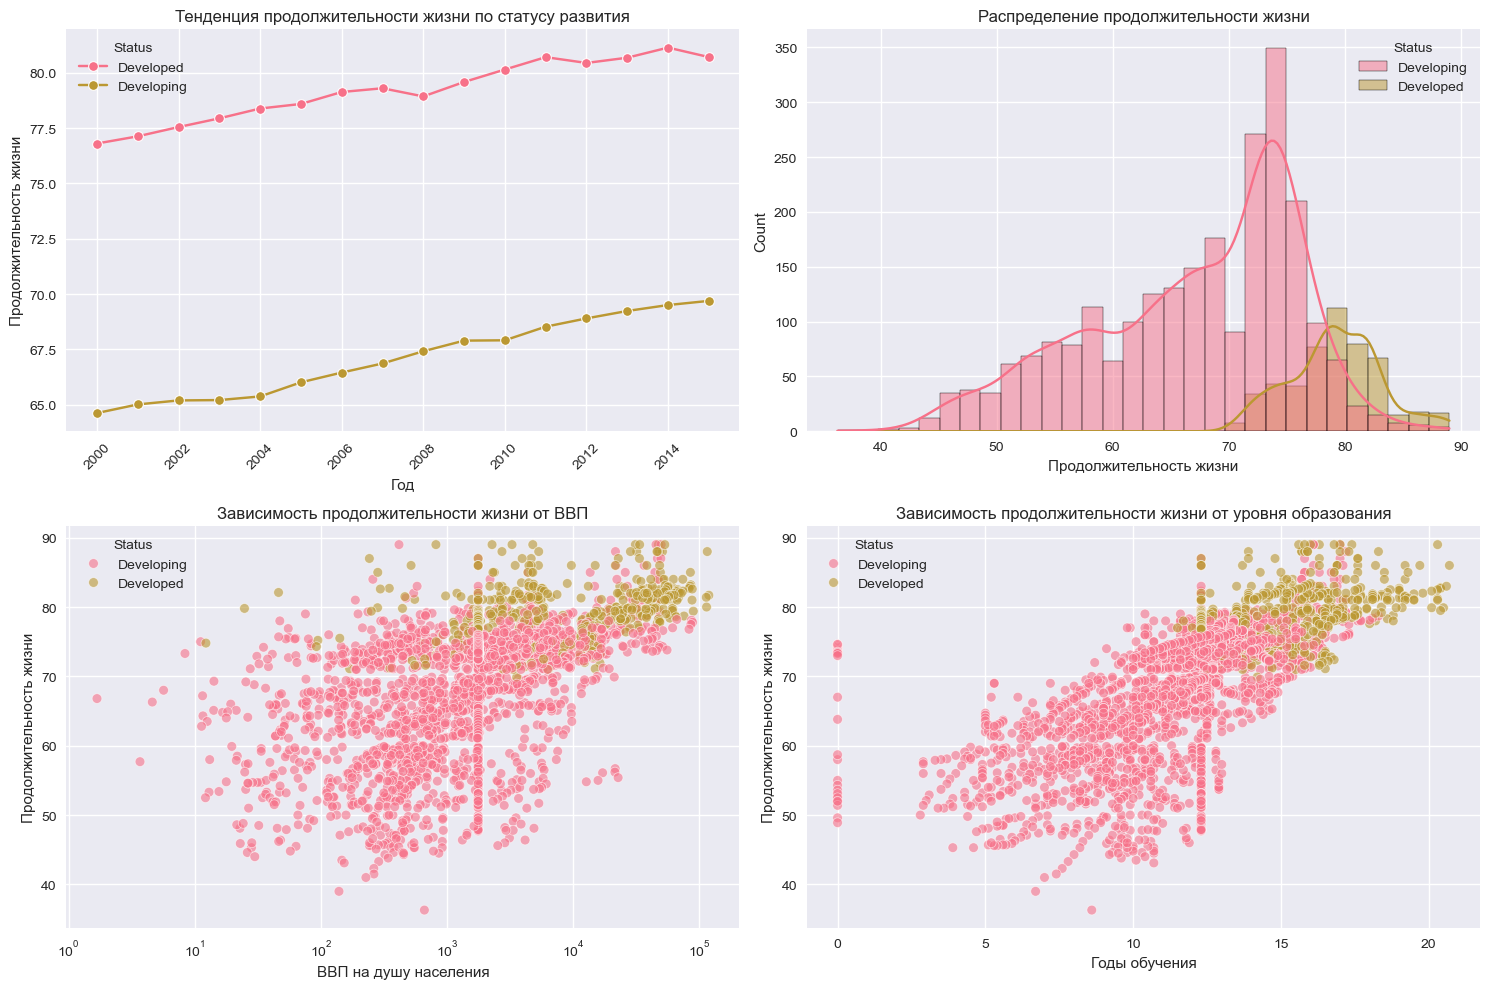

In [7]:
plt.figure(figsize=(15, 10))

# График 1: Тенденция продолжительности жизни по статусу развития
plt.subplot(2, 2, 1)
yearly_life_exp = df_clean.groupby(['Year', 'Status'])['Life expectancy '].mean().reset_index()
sns.lineplot(data=yearly_life_exp, x='Year', y='Life expectancy ', hue='Status', marker='o')
plt.title('Тенденция продолжительности жизни по статусу развития')
plt.xlabel('Год')
plt.ylabel('Продолжительность жизни')
plt.xticks(rotation=45)

# График 2: Распределение продолжительности жизни
plt.subplot(2, 2, 2)
sns.histplot(data=df_clean, x='Life expectancy ', hue='Status', kde=True, bins=30)
plt.title('Распределение продолжительности жизни')
plt.xlabel('Продолжительность жизни')

# График 3: Зависимость продолжительности жизни от ВВП
plt.subplot(2, 2, 3)
sns.scatterplot(data=df_clean, x='GDP', y='Life expectancy ', hue='Status', alpha=0.6)
plt.title('Зависимость продолжительности жизни от ВВП')
plt.xlabel('ВВП на душу населения')
plt.ylabel('Продолжительность жизни')
plt.xscale('log')

# График 4:Зависимость продолжительности жизни от уровня образования
plt.subplot(2, 2, 4)
sns.scatterplot(data=df_clean, x='Schooling', y='Life expectancy ', hue='Status', alpha=0.6)
plt.title('Зависимость продолжительности жизни от уровня образования')
plt.xlabel('Годы обучения')
plt.ylabel('Продолжительность жизни')

plt.tight_layout()
plt.show()

Вывод: Наблюдается четкое разделение между развитыми и развивающимися странами по продолжительности жизни. ВВП и уровень образования сильно коррелируют с продолжительностью жизни.

**Визуализация 2: Факторы здоровья и их влияние**

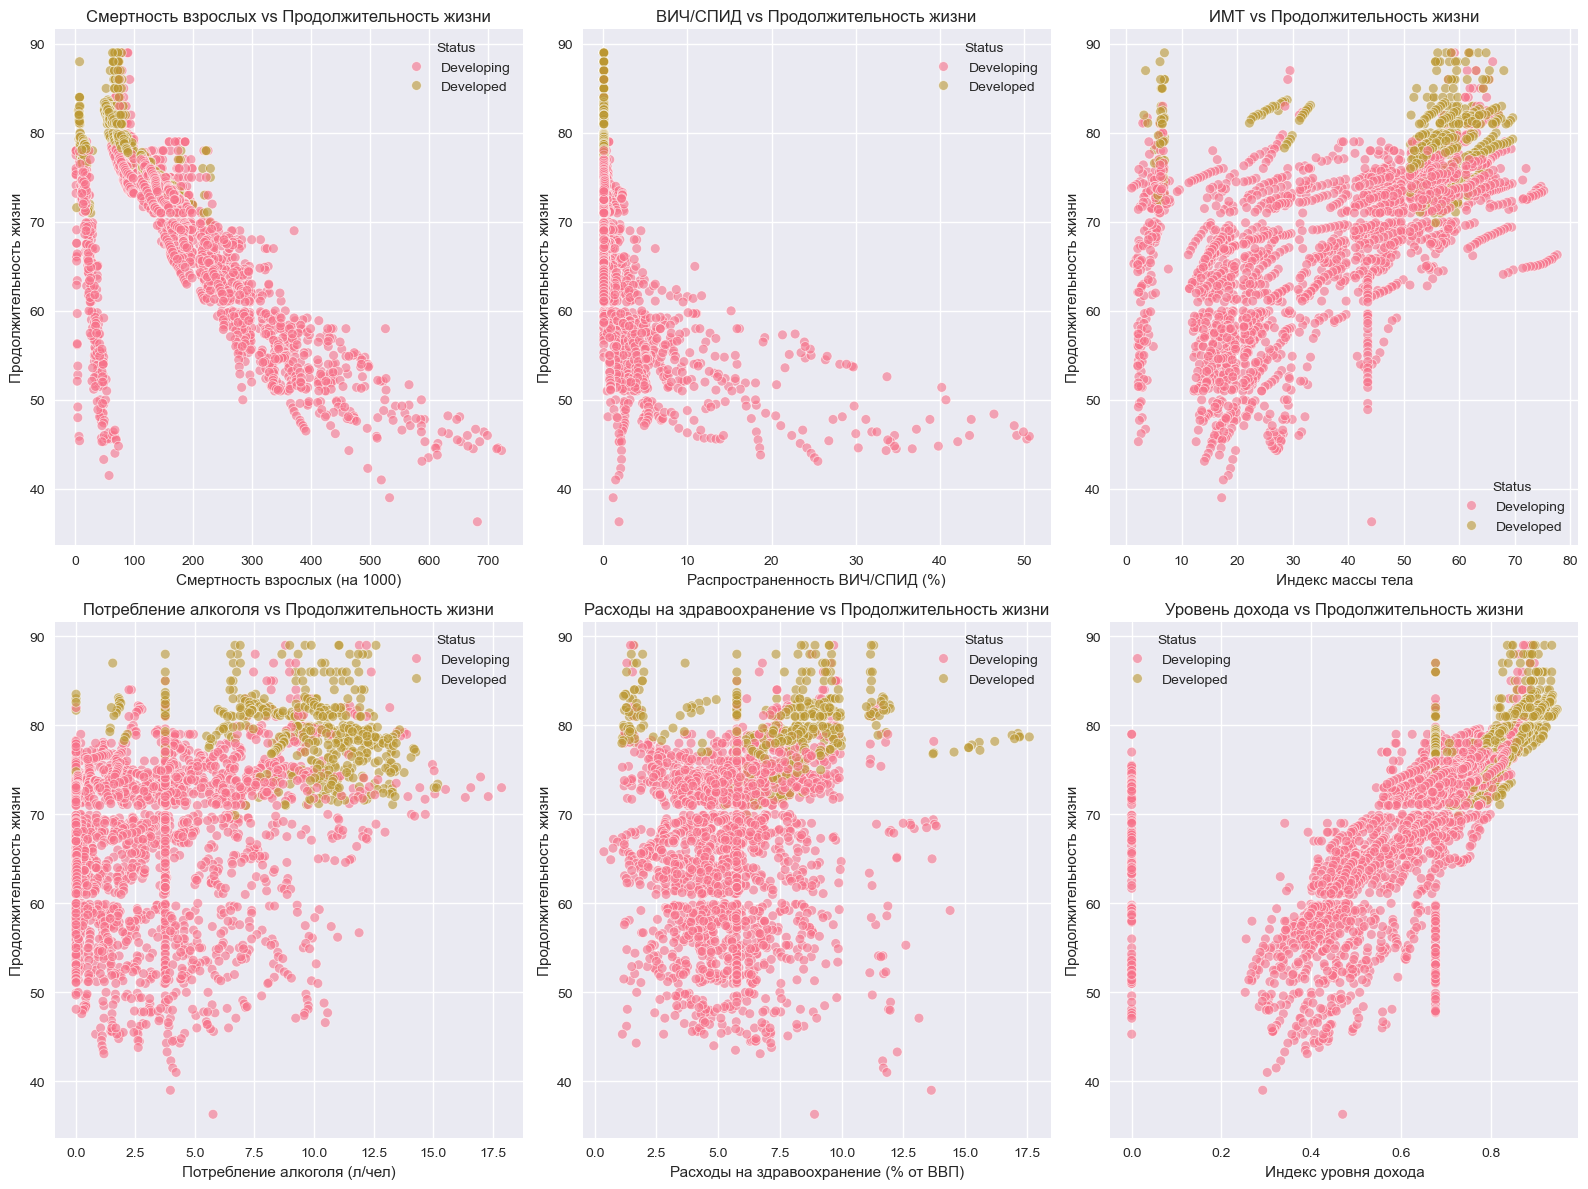

In [8]:
plt.figure(figsize=(16, 12))

# График 1: Смертность взрослых vs Продолжительность жизни
plt.subplot(2, 3, 1)
sns.scatterplot(data=df_clean, x='Adult Mortality', y='Life expectancy ', hue='Status', alpha=0.6)
plt.title('Смертность взрослых vs Продолжительность жизни')
plt.xlabel('Смертность взрослых (на 1000)')
plt.ylabel('Продолжительность жизни')

# График 2: ВИЧ/СПИД
plt.subplot(2, 3, 2)
sns.scatterplot(data=df_clean, x=' HIV/AIDS', y='Life expectancy ', hue='Status', alpha=0.6)
plt.title('ВИЧ/СПИД vs Продолжительность жизни')
plt.xlabel('Распространенность ВИЧ/СПИД (%)')
plt.ylabel('Продолжительность жизни')

# График 3: ИМТ
plt.subplot(2, 3, 3)
sns.scatterplot(data=df_clean, x=' BMI ', y='Life expectancy ', hue='Status', alpha=0.6)
plt.title('ИМТ vs Продолжительность жизни')
plt.xlabel('Индекс массы тела')
plt.ylabel('Продолжительность жизни')

# График 4: Потребление алкоголя
plt.subplot(2, 3, 4)
sns.scatterplot(data=df_clean, x='Alcohol', y='Life expectancy ', hue='Status', alpha=0.6)
plt.title('Потребление алкоголя vs Продолжительность жизни')
plt.xlabel('Потребление алкоголя (л/чел)')
plt.ylabel('Продолжительность жизни')

# График 5: Расходы на здравоохранение
plt.subplot(2, 3, 5)
sns.scatterplot(data=df_clean, x='Total expenditure', y='Life expectancy ', hue='Status', alpha=0.6)
plt.title('Расходы на здравоохранение vs Продолжительность жизни')
plt.xlabel('Расходы на здравоохранение (% от ВВП)')
plt.ylabel('Продолжительность жизни')

# График 6: Уровень дохода
plt.subplot(2, 3, 6)
sns.scatterplot(data=df_clean, x='Income composition of resources', y='Life expectancy ', hue='Status', alpha=0.6)
plt.title('Уровень дохода vs Продолжительность жизни')
plt.xlabel('Индекс уровня дохода')
plt.ylabel('Продолжительность жизни')

plt.tight_layout()
plt.show()

Вывод: Смертность взрослых и распространенность ВИЧ/СПИД оказывают значительное негативное влияние на продолжительность жизни. Уровень дохода положительно коррелирует с продолжительностью жизни.

**Визуализация 3: Детская смертность и иммунизация**

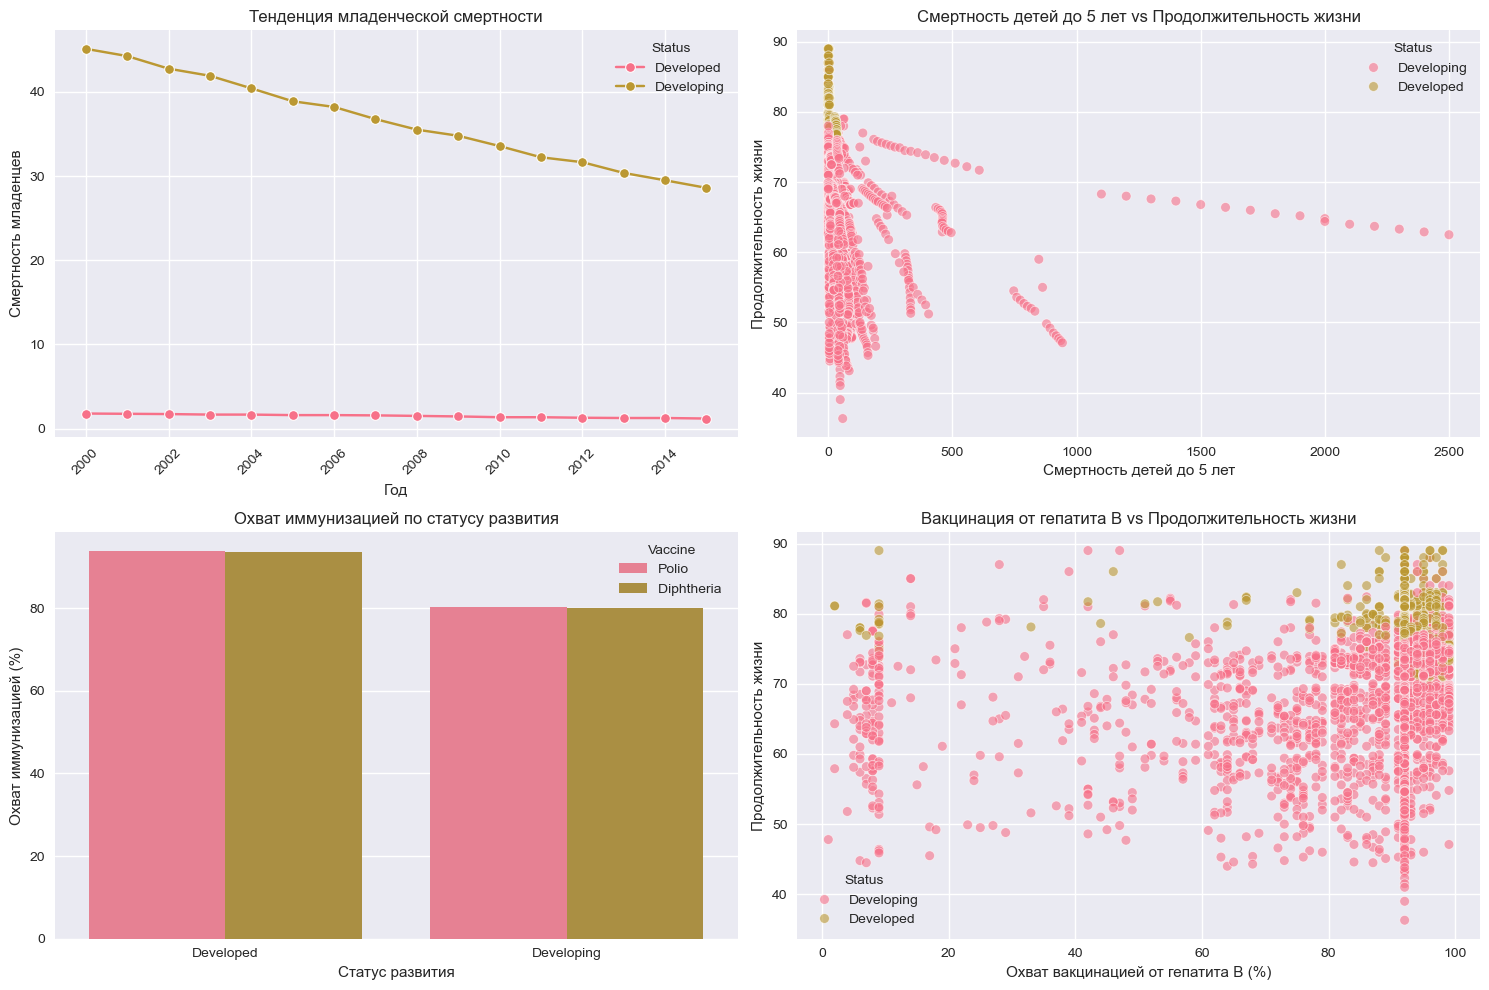

In [9]:
plt.figure(figsize=(15, 10))

# График 1: Тенденция младенческой смерти
plt.subplot(2, 2, 1)
yearly_infant = df_clean.groupby(['Year', 'Status'])['infant deaths'].mean().reset_index()
sns.lineplot(data=yearly_infant, x='Year', y='infant deaths', hue='Status', marker='o')
plt.title('Тенденция младенческой смертности')
plt.xlabel('Год')
plt.ylabel('Смертность младенцев')
plt.xticks(rotation=45)

# График 2: Смертность детей до 5 лет vs Продолжительность жизни
plt.subplot(2, 2, 2)
sns.scatterplot(data=df_clean, x='under-five deaths ', y='Life expectancy ', hue='Status', alpha=0.6)
plt.title('Смертность детей до 5 лет vs Продолжительность жизни')
plt.xlabel('Смертность детей до 5 лет')
plt.ylabel('Продолжительность жизни')

# График 3: Иммунизация
plt.subplot(2, 2, 3)
immunization_data = df_clean.groupby('Status')[['Polio', 'Diphtheria ']].mean().reset_index()
immunization_melted = immunization_data.melt(id_vars=['Status'], value_vars=['Polio', 'Diphtheria '],
                                          var_name='Vaccine', value_name='Coverage')
sns.barplot(data=immunization_melted, x='Status', y='Coverage', hue='Vaccine')
plt.title('Охват иммунизацией по статусу развития')
plt.xlabel('Статус развития')
plt.ylabel('Охват иммунизацией (%)')

# График 4: Гепатит Б
plt.subplot(2, 2, 4)
sns.scatterplot(data=df_clean, x='Hepatitis B', y='Life expectancy ', hue='Status', alpha=0.6)
plt.title('Вакцинация от гепатита B vs Продолжительность жизни')
plt.xlabel('Охват вакцинацией от гепатита B (%)')
plt.ylabel('Продолжительность жизни')

plt.tight_layout()
plt.show()

Вывод: Развитые страны демонстрируют значительно более низкие показатели детской смертности и более высокий охват иммунизацией, что положительно влияет на общую продолжительность жизни.

**Визуализация 4: Корреляционный анализ**

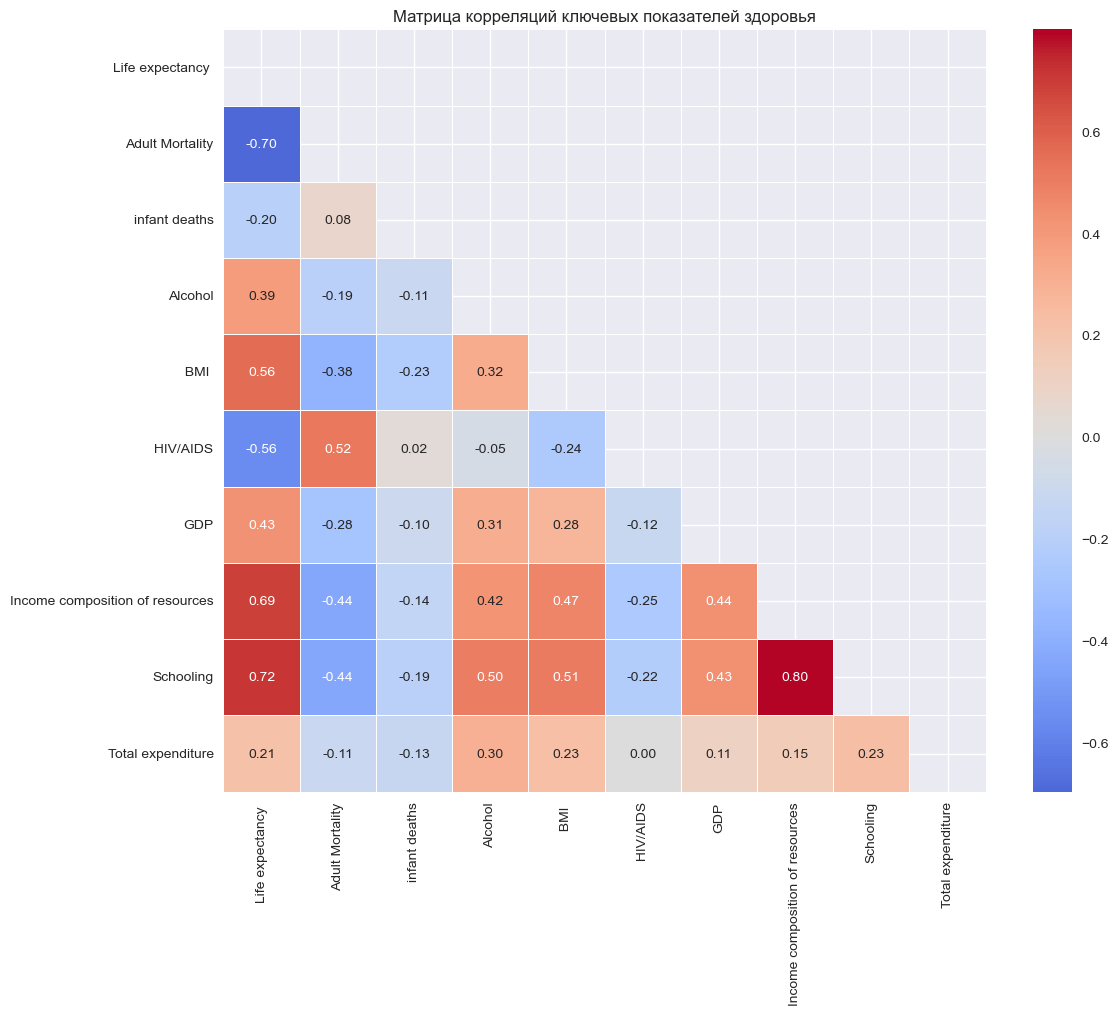

In [10]:
plt.figure(figsize=(12, 10))

correlation_cols = ['Life expectancy ', 'Adult Mortality', 'infant deaths', 'Alcohol',
                   ' BMI ', ' HIV/AIDS', 'GDP', 'Income composition of resources',
                   'Schooling', 'Total expenditure']

correlation_matrix = df_clean[correlation_cols].corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
           square=True, linewidths=0.5, fmt='.2f')
plt.title('Матрица корреляций ключевых показателей здоровья')
plt.tight_layout()
plt.show()

Вывод: Наибольшую положительную корреляцию с продолжительностью жизни имеют уровень образования (0.72), доход (0.69) и ИМС (0.56). Наибольшую отрицательную корреляцию демонстрируют смертность взрослых (-0.70) и ВИЧ/СПИД (-0.56).

**Визуализация 5: Региональные различия (топ-10 стран)**

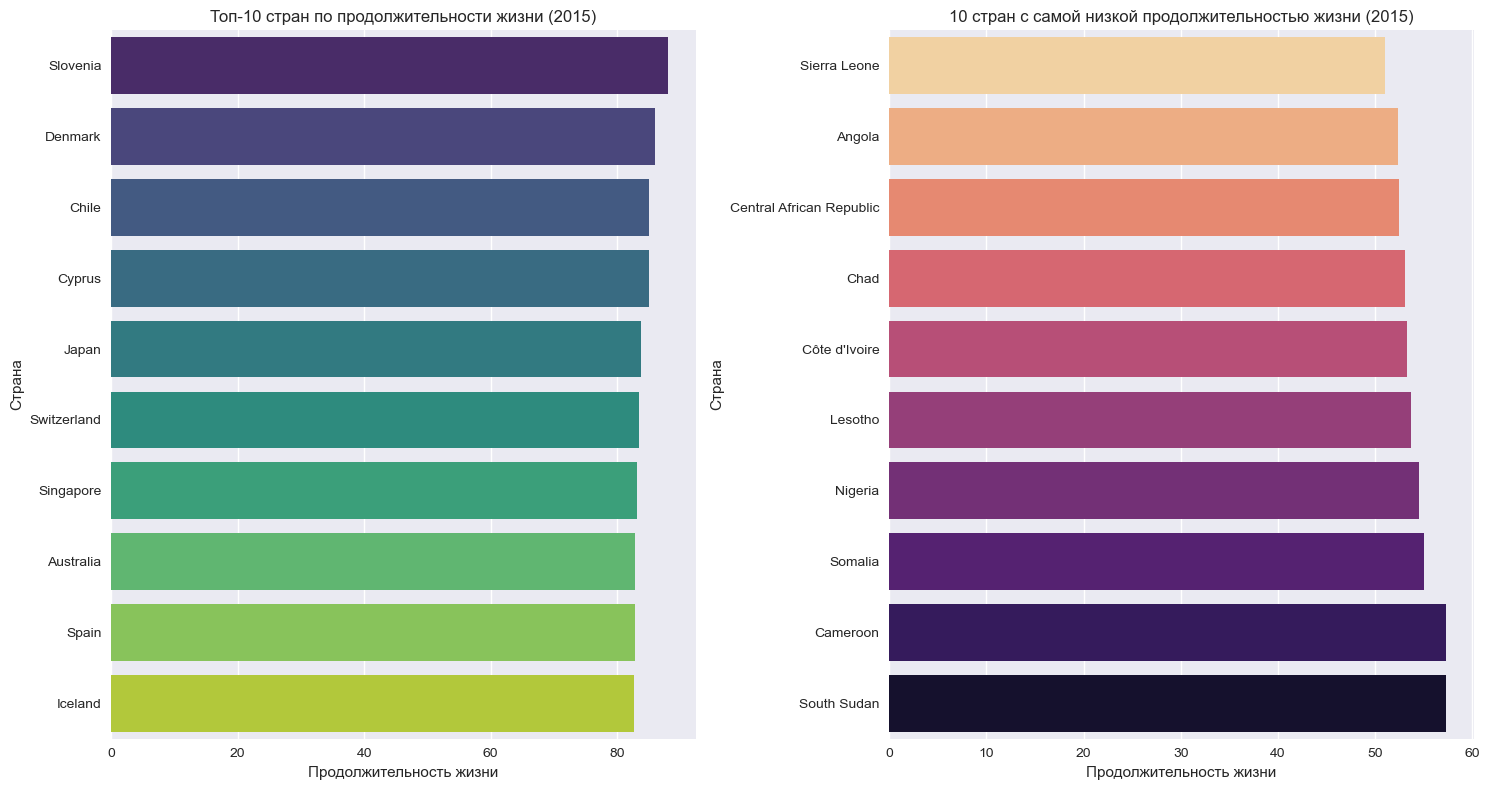

In [11]:
latest_year = df_clean['Year'].max()
latest_data = df_clean[df_clean['Year'] == latest_year]

top_10 = latest_data.nlargest(10, 'Life expectancy ')

bottom_10 = latest_data.nsmallest(10, 'Life expectancy ')

plt.figure(figsize=(15, 8))

# График 1: Лучшие 10 стран по продолжительности жизни
plt.subplot(1, 2, 1)
sns.barplot(data=top_10, y='Country', x='Life expectancy ', palette='viridis')
plt.title(f'Топ-10 стран по продолжительности жизни ({latest_year})')
plt.xlabel('Продолжительность жизни')
plt.ylabel('Страна')

# График 2: Худшие 10 стран по продолжительности жизни
plt.subplot(1, 2, 2)
sns.barplot(data=bottom_10, y='Country', x='Life expectancy ', palette='magma_r')
plt.title(f'10 стран с самой низкой продолжительностью жизни ({latest_year})')
plt.xlabel('Продолжительность жизни')
plt.ylabel('Страна')

plt.tight_layout()
plt.show()

Вывод: Значительные различия в продолжительности жизни между странами демонстрируют глобальное неравенство в доступе к качественному здравоохранению.

**Работа с моделями**

In [12]:
print("=== ПОДГОТОВКА ДАННЫХ ДЛЯ МОДЕЛИРОВАНИЯ ===")
df_ml = df_clean.copy()

# Выбор признаков и целевой переменной
features = ['Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure',
            'Hepatitis B', 'Measles ', ' BMI ', 'under-five deaths ',
            'Polio', 'Total expenditure', 'Diphtheria ', ' HIV/AIDS', 'GDP',
            'Population', ' thinness  1-19 years', ' thinness 5-9 years',
            'Income composition of resources', 'Schooling', 'Status_numeric']

X = df_ml[features]
y = df_ml['Life expectancy ']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"Количество признаков: {len(features)}")

=== ПОДГОТОВКА ДАННЫХ ДЛЯ МОДЕЛИРОВАНИЯ ===
Размер обучающей выборки: (2342, 19)
Размер тестовой выборки: (586, 19)
Количество признаков: 19


In [13]:
print("\n=== 1. ТЕСТИРОВАНИЕ РАЗНООБРАЗНЫХ МОДЕЛЕЙ ===")

models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Support Vector Regression': SVR(),
    'K-Neighbors Regressor': KNeighborsRegressor(n_neighbors=5),
    'XGBoost': xgb.XGBRegressor(random_state=42, verbosity=0),
    'LightGBM': lgb.LGBMRegressor(random_state=42, verbose=-1)
}

results = {}

for name, model in models.items():
    print(f"\nОбучение модели: {name}")
    start_time = time.time()
    
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    
    # Вычисление метрик
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    train_time = time.time() - start_time
    
    results[name] = {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'Time': train_time
    }
    
    print(f"  MAE: {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R2 Score: {r2:.4f}")
    print(f"  Время обучения: {train_time:.2f} сек")

results_df = pd.DataFrame(results).T
print("\n=== СРАВНЕНИЕ МОДЕЛЕЙ ===")
print(results_df.sort_values('R2', ascending=False))


=== 1. ТЕСТИРОВАНИЕ РАЗНООБРАЗНЫХ МОДЕЛЕЙ ===

Обучение модели: Linear Regression
  MAE: 2.9281
  RMSE: 3.9527
  R2 Score: 0.8194
  Время обучения: 0.02 сек

Обучение модели: Decision Tree
  MAE: 1.5720
  RMSE: 2.6269
  R2 Score: 0.9202
  Время обучения: 0.03 сек

Обучение модели: Random Forest
  MAE: 1.0727
  RMSE: 1.7179
  R2 Score: 0.9659
  Время обучения: 1.62 сек

Обучение модели: Gradient Boosting
  MAE: 1.5155
  RMSE: 2.1326
  R2 Score: 0.9474
  Время обучения: 0.61 сек

Обучение модели: Support Vector Regression
  MAE: 2.3470
  RMSE: 3.4506
  R2 Score: 0.8623
  Время обучения: 0.24 сек

Обучение модели: K-Neighbors Regressor
  MAE: 1.8849
  RMSE: 2.8648
  R2 Score: 0.9051
  Время обучения: 0.16 сек

Обучение модели: XGBoost
  MAE: 1.1263
  RMSE: 1.6635
  R2 Score: 0.9680
  Время обучения: 0.31 сек

Обучение модели: LightGBM
  MAE: 1.1726
  RMSE: 1.7696
  R2 Score: 0.9638
  Время обучения: 0.05 сек

=== СРАВНЕНИЕ МОДЕЛЕЙ ===
                                MAE      RMSE        

**Визуализация работы моделей**

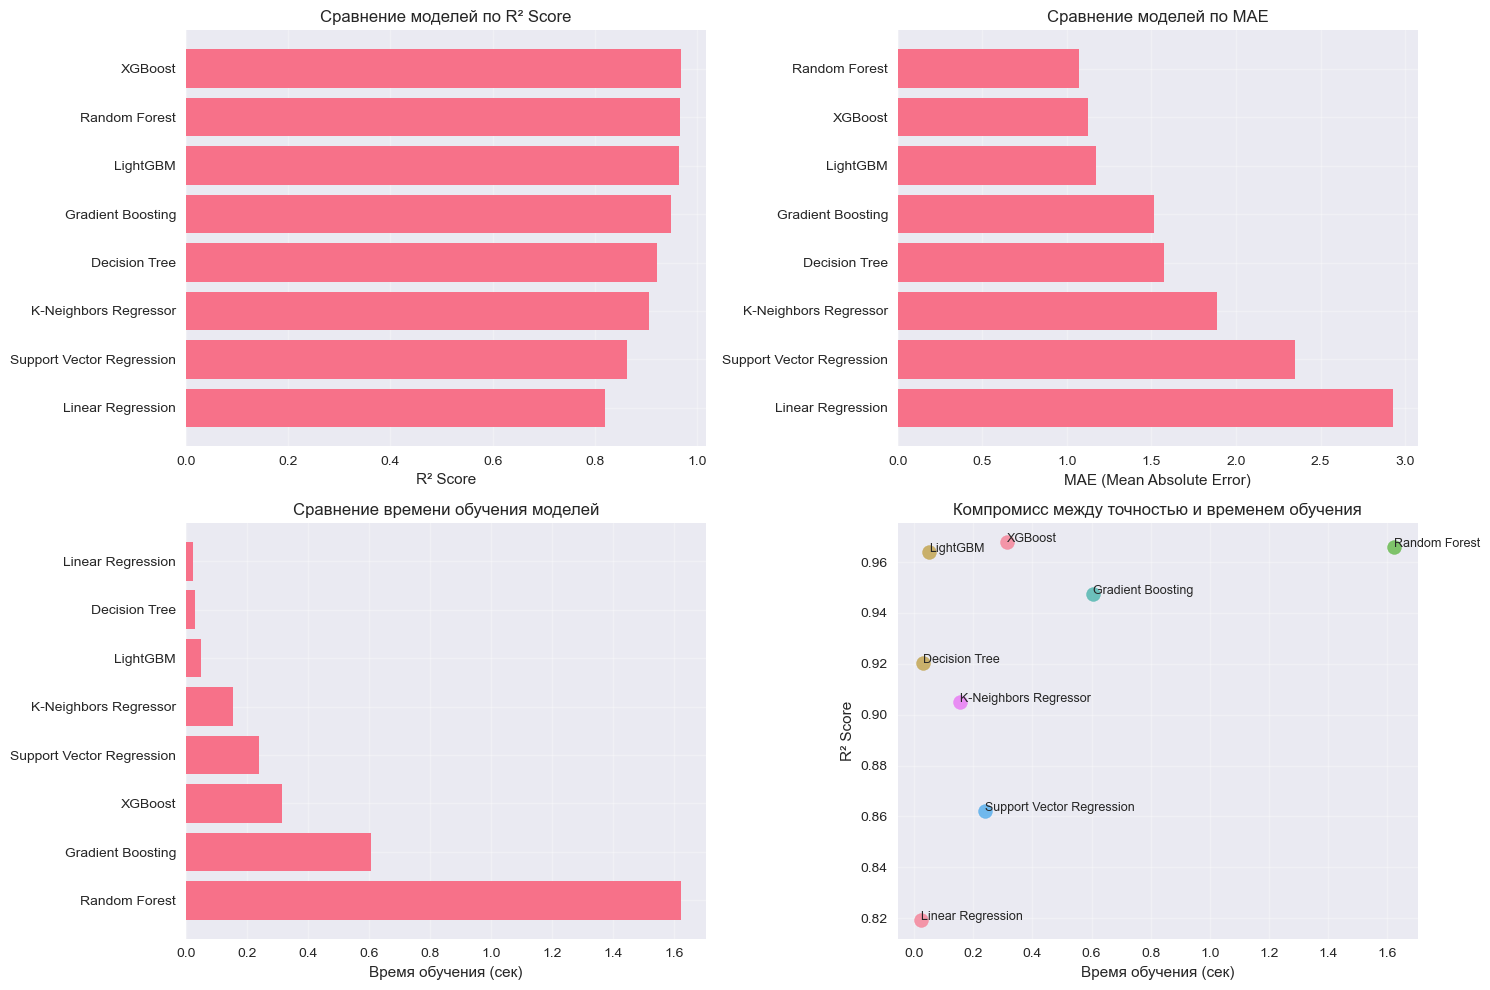

In [15]:
plt.figure(figsize=(15, 10))

# График 1: Сравнение R2 Score
plt.subplot(2, 2, 1)
sorted_results = results_df.sort_values('R2', ascending=True)
plt.barh(range(len(sorted_results)), sorted_results['R2'])
plt.yticks(range(len(sorted_results)), sorted_results.index)
plt.xlabel('R² Score')
plt.title('Сравнение моделей по R² Score')
plt.grid(True, alpha=0.3)

# График 2: Сравнение MAE
plt.subplot(2, 2, 2)
sorted_mae = results_df.sort_values('MAE', ascending=False)
plt.barh(range(len(sorted_mae)), sorted_mae['MAE'])
plt.yticks(range(len(sorted_mae)), sorted_mae.index)
plt.xlabel('MAE (Mean Absolute Error)')
plt.title('Сравнение моделей по MAE')
plt.grid(True, alpha=0.3)

# График 3: Сравнение времени обучения
plt.subplot(2, 2, 3)
sorted_time = results_df.sort_values('Time', ascending=False)
plt.barh(range(len(sorted_time)), sorted_time['Time'])
plt.yticks(range(len(sorted_time)), sorted_time.index)
plt.xlabel('Время обучения (сек)')
plt.title('Сравнение времени обучения моделей')
plt.grid(True, alpha=0.3)

# График 4: Компромисс точность/время
plt.subplot(2, 2, 4)
for model in results_df.index:
    plt.scatter(results_df.loc[model, 'Time'], 
                results_df.loc[model, 'R2'], 
                s=100, alpha=0.7)
    plt.annotate(model, 
                (results_df.loc[model, 'Time'], 
                 results_df.loc[model, 'R2']),
                fontsize=9)
plt.xlabel('Время обучения (сек)')
plt.ylabel('R² Score')
plt.title('Компромисс между точностью и временем обучения')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Анализ важности признаков модели LightGBM**


=== 2. АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ ===

Топ-10 наиболее важных признаков:
                            feature  importance
0                   Adult Mortality         521
16  Income composition of resources         228
2                           Alcohol         209
9                 Total expenditure         208
13                       Population         171
17                        Schooling         168
11                         HIV/AIDS         157
6                              BMI          155
15               thinness 5-9 years         152
14             thinness  1-19 years         145


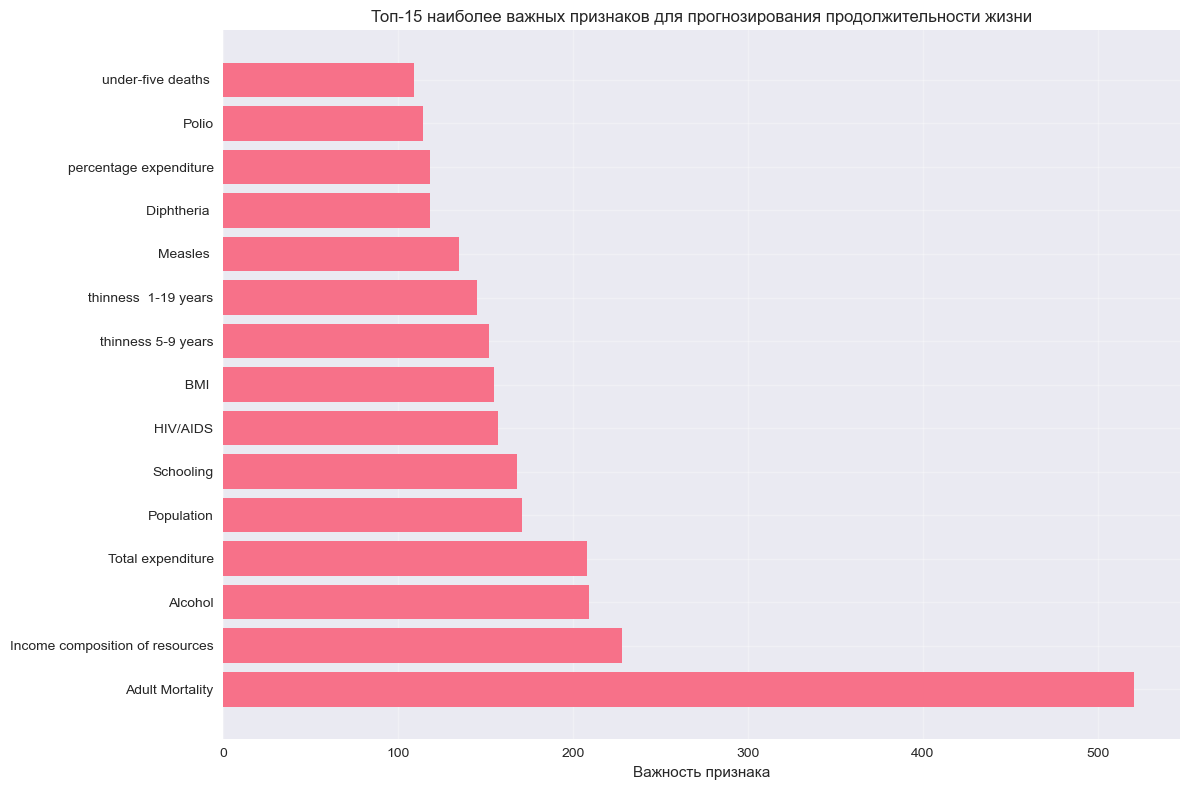


Анализ важности признаков:
1. Adult Mortality - смертность взрослого населения
2. Income composition of resources - индекс уровня дохода (один из наиболее важных)
3. Alcohol - алкоголизм
4. Total expenditure - расходы
5. Population - население

Вывод: Экономические и социальные факторы имеют наибольшее влияние.


In [17]:
print("\n=== 2. АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ ===")

best_model = lgb.LGBMRegressor(random_state=42, verbose=-1)
best_model.fit(X_train_scaled, y_train)

# Получаем важность признаков
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nТоп-10 наиболее важных признаков:")
print(feature_importance.head(10))

# Визуализация важности признаков
plt.figure(figsize=(12, 8))
plt.barh(range(15), feature_importance['importance'][:15])
plt.yticks(range(15), feature_importance['feature'][:15])
plt.xlabel('Важность признака')
plt.title('Топ-15 наиболее важных признаков для прогнозирования продолжительности жизни')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nАнализ важности признаков:")
print("1. Adult Mortality - смертность взрослого населения")
print("2. Income composition of resources - индекс уровня дохода (один из наиболее важных)")
print("3. Alcohol - алкоголизм")
print("4. Total expenditure - расходы")
print("5. Population - население")
print("\nВывод: Экономические и социальные факторы имеют наибольшее влияние.")

**Улучшение модели - подбор гиперпараметров**

In [18]:
print("\n=== 3. УЛУЧШЕНИЕ МОДЕЛИ (LightGBM) ===")

# Первоначальная оценка
initial_predictions = best_model.predict(X_test_scaled)
initial_r2 = r2_score(y_test, initial_predictions)
print(f"Начальная производительность (R²): {initial_r2:.4f}")

# Используем уменьшенный набор данных для быстрого поиска
X_small, _, y_small, _ = train_test_split(
    X_train_scaled, y_train, test_size=0.7, random_state=42
)

# Подбор гиперпараметров для LightGBM
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'num_leaves': [31, 50, 100],
    'subsample': [0.8, 0.9, 1.0]
}

print("Начинаем поиск оптимальных гиперпараметров...")
start_time = time.time()

grid_search = GridSearchCV(
    lgb.LGBMRegressor(random_state=42, verbose=-1),
    param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=0
)

grid_search.fit(X_small, y_small)

print(f"Поиск завершен за {time.time() - start_time:.2f} сек")
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучшая оценка (R²) на кросс-валидации: {grid_search.best_score_:.4f}")

# Обучение улучшенной модели на всех данных
improved_model = grid_search.best_estimator_
improved_model.fit(X_train_scaled, y_train)

# Прогнозирование улучшенной моделью
improved_predictions = improved_model.predict(X_test_scaled)
improved_r2 = r2_score(y_test, improved_predictions)

print(f"\nПроизводительность улучшенной модели (R²): {improved_r2:.4f}")
print(f"Улучшение: {improved_r2 - initial_r2:.4f} (+{(improved_r2/initial_r2 - 1)*100:.2f}%)")


=== 3. УЛУЧШЕНИЕ МОДЕЛИ (LightGBM) ===
Начальная производительность (R²): 0.9638
Начинаем поиск оптимальных гиперпараметров...
Поиск завершен за 17.78 сек
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'num_leaves': 31, 'subsample': 0.8}
Лучшая оценка (R²) на кросс-валидации: 0.9240

Производительность улучшенной модели (R²): 0.9654
Улучшение: 0.0016 (+0.17%)



=== 4. АНСАМБЛИ МОДЕЛЕЙ И СТЕККИНГ ===
4.1. Voting Regressor (усреднение прогнозов)
  R² Score Voting Regressor: 0.9694
  Время обучения: 1.7741 сек
  Время предсказания: 0.0170 сек

4.2. Stacking Regressor (многоуровневый ансамбль)
  R² Score Stacking Regressor: 0.9692
  Время обучения: 8.8818 сек
  Время предсказания: 0.0170 сек

=== ИТОГОВОЕ СРАВНЕНИЕ МОДЕЛЕЙ ===
                   Model  R² Score       MAE
2        Voting Ensemble  0.969393  1.038843
3      Stacking Ensemble  0.969180  1.033845
1  LightGBM (улучшенный)  0.965392  1.140352
0     LightGBM (базовый)  0.963799  1.172570


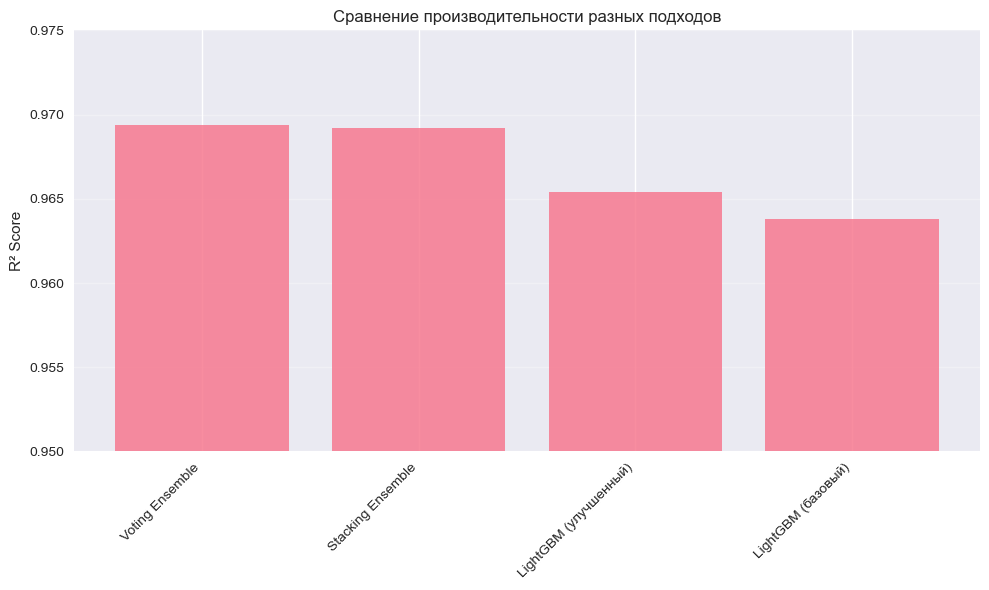

In [31]:
print("\n=== 4. АНСАМБЛИ МОДЕЛЕЙ И СТЕККИНГ ===")

from sklearn.ensemble import VotingRegressor, StackingRegressor

# Создаем ансамбль из моделей
ensemble_models = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('xgb', xgb.XGBRegressor(random_state=42, verbosity=0)),
    ('lgb', lgb.LGBMRegressor(random_state=42, verbose=-1))
]

# 4.1. Voting Regressor (усреднение прогнозов)
print("4.1. Voting Regressor (усреднение прогнозов)")

start_time = time.time()
voting_reg = VotingRegressor(estimators=ensemble_models)
voting_reg.fit(X_train_scaled, y_train)
fit_time_voting = time.time() - start_time

start_time = time.time()
y_pred_voting = voting_reg.predict(X_test_scaled)
pred_time_voting = time.time() - start_time

voting_r2 = r2_score(y_test, y_pred_voting)
print(f"  R² Score Voting Regressor: {voting_r2:.4f}")
print(f"  Время обучения: {fit_time_voting:.4f} сек")
print(f"  Время предсказания: {pred_time_voting:.4f} сек")

# 4.2. Stacking Regressor (многоуровневый ансамбль)
print("\n4.2. Stacking Regressor (многоуровневый ансамбль)")

start_time = time.time()
stacking_reg = StackingRegressor(
    estimators=ensemble_models,
    final_estimator=LinearRegression(),
    cv=5
)
stacking_reg.fit(X_train_scaled, y_train)
fit_time_stacking = time.time() - start_time

start_time = time.time()
y_pred_stacking = stacking_reg.predict(X_test_scaled)
pred_time_stacking = time.time() - start_time

stacking_r2 = r2_score(y_test, y_pred_stacking)
print(f"  R² Score Stacking Regressor: {stacking_r2:.4f}")
print(f"  Время обучения: {fit_time_stacking:.4f} сек")
print(f"  Время предсказания: {pred_time_stacking:.4f} сек")

# === ИТОГОВОЕ СРАВНЕНИЕ МОДЕЛЕЙ ===
print("\n=== ИТОГОВОЕ СРАВНЕНИЕ МОДЕЛЕЙ ===")

comparison = pd.DataFrame({
    'Model': ['LightGBM (базовый)', 'LightGBM (улучшенный)', 
              'Voting Ensemble', 'Stacking Ensemble'],
    'R² Score': [initial_r2, improved_r2, voting_r2, stacking_r2],
    'MAE': [
        mean_absolute_error(y_test, initial_predictions),
        mean_absolute_error(y_test, improved_predictions),
        mean_absolute_error(y_test, y_pred_voting),
        mean_absolute_error(y_test, y_pred_stacking)
    ]
}).sort_values('R² Score', ascending=False)

print(comparison)

# Визуализация сравнения ансамблей
plt.figure(figsize=(10, 6))
x_pos = np.arange(len(comparison))
plt.bar(x_pos, comparison['R² Score'], alpha=0.8)
plt.xticks(x_pos, comparison['Model'], rotation=45, ha='right')
plt.ylabel('R² Score')
plt.title('Сравнение производительности разных подходов')
plt.ylim(0.95, 0.975)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

**Анализ ошибок**


=== 5. АНАЛИЗ ОШИБОК МОДЕЛИ ===


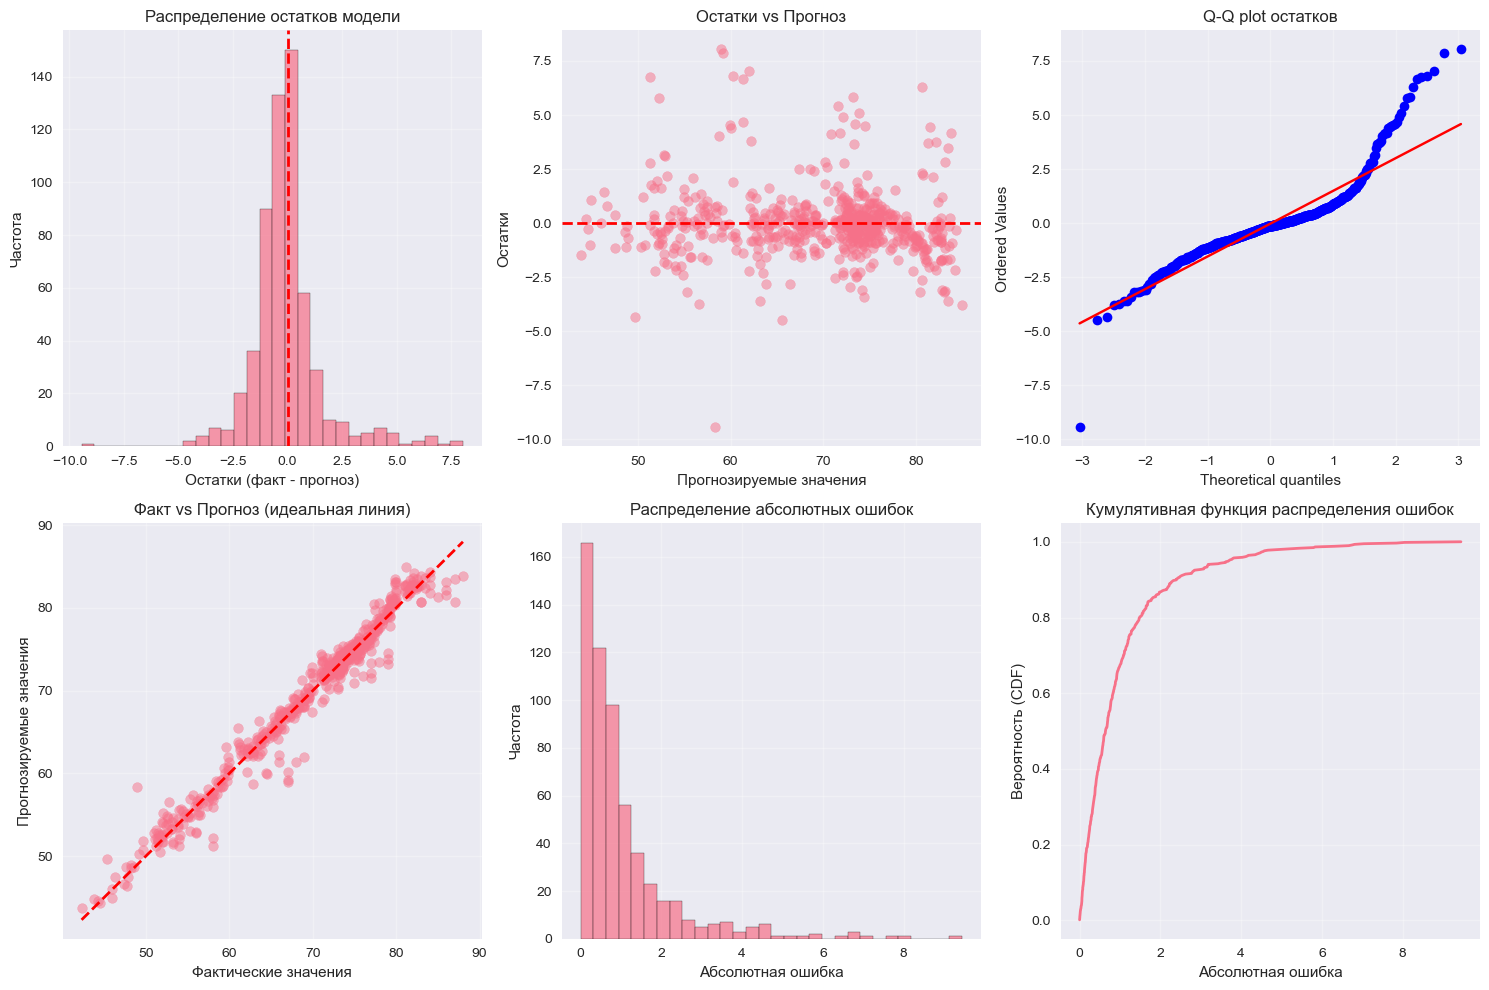


Статистика ошибок модели:
Средняя абсолютная ошибка (MAE): 1.0338
Медианная абсолютная ошибка: 0.6428
90-й перцентиль абсолютной ошибки: 2.3950
95-й перцентиль абсолютной ошибки: 3.6956
Максимальная абсолютная ошибка: 9.4402

Страны с наибольшими ошибками прогноза:
                               Country  Year  Life expectancy   Predicted  \
2424                       South Sudan  2000              48.9  58.340249   
2922                          Zimbabwe  2015              67.0  58.960676   
2779       United Republic of Tanzania  2014              67.0  59.153818   
1564                        Madagascar  2005              69.0  61.961994   
2716                            Uganda  2013              67.0  60.192360   
2790       United Republic of Tanzania  2003              58.0  51.256132   
963                             Gambia  2014              68.0  61.336122   
2322                         Singapore  2006              87.0  80.693330   
2198  Saint Vincent and the Grenadines  

In [20]:
print("\n=== 5. АНАЛИЗ ОШИБОК МОДЕЛИ ===")

# Используем лучшую модель для анализа ошибок
final_predictions = stacking_reg.predict(X_test_scaled)
residuals = y_test - final_predictions

plt.figure(figsize=(15, 10))

# График 1: Распределение остатков
plt.subplot(2, 3, 1)
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Остатки (факт - прогноз)')
plt.ylabel('Частота')
plt.title('Распределение остатков модели')
plt.grid(True, alpha=0.3)

# График 2: Остатки vs Прогноз
plt.subplot(2, 3, 2)
plt.scatter(final_predictions, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Прогнозируемые значения')
plt.ylabel('Остатки')
plt.title('Остатки vs Прогноз')
plt.grid(True, alpha=0.3)

# График 3: Q-Q plot для проверки нормальности
plt.subplot(2, 3, 3)
from scipy import stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q plot остатков')
plt.grid(True, alpha=0.3)

# График 4: Факт vs Прогноз
plt.subplot(2, 3, 4)
plt.scatter(y_test, final_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', linewidth=2)
plt.xlabel('Фактические значения')
plt.ylabel('Прогнозируемые значения')
plt.title('Факт vs Прогноз (идеальная линия)')
plt.grid(True, alpha=0.3)

# График 5: Абсолютные ошибки
plt.subplot(2, 3, 5)
absolute_errors = np.abs(residuals)
plt.hist(absolute_errors, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Абсолютная ошибка')
plt.ylabel('Частота')
plt.title('Распределение абсолютных ошибок')
plt.grid(True, alpha=0.3)

# График 6: Кумулятивная функция распределения ошибок
plt.subplot(2, 3, 6)
sorted_errors = np.sort(absolute_errors)
cdf = np.arange(1, len(sorted_errors)+1) / len(sorted_errors)
plt.plot(sorted_errors, cdf, linewidth=2)
plt.xlabel('Абсолютная ошибка')
plt.ylabel('Вероятность (CDF)')
plt.title('Кумулятивная функция распределения ошибок')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Статистика ошибок
print("\nСтатистика ошибок модели:")
print(f"Средняя абсолютная ошибка (MAE): {np.mean(absolute_errors):.4f}")
print(f"Медианная абсолютная ошибка: {np.median(absolute_errors):.4f}")
print(f"90-й перцентиль абсолютной ошибки: {np.percentile(absolute_errors, 90):.4f}")
print(f"95-й перцентиль абсолютной ошибки: {np.percentile(absolute_errors, 95):.4f}")
print(f"Максимальная абсолютная ошибка: {np.max(absolute_errors):.4f}")

# Анализ стран с наибольшими ошибками
test_indices = X_test.index
df_test = df_clean.loc[test_indices].copy()
df_test['Predicted'] = final_predictions
df_test['Error'] = np.abs(df_test['Life expectancy '] - df_test['Predicted'])
df_test['Relative_Error'] = df_test['Error'] / df_test['Life expectancy '] * 100

print("\nСтраны с наибольшими ошибками прогноза:")
top_errors = df_test.sort_values('Error', ascending=False).head(10)
print(top_errors[['Country', 'Year', 'Life expectancy ', 'Predicted', 'Error', 'Relative_Error']])

**Прогнозирование для новых данных и интерпретация**

In [26]:
print("\n=== 6. ПРОГНОЗИРОВАНИЕ И ИНТЕРПРЕТАЦИЯ ===")

# Создаем примеры стран для прогнозирования
print("\nПримеры прогнозирования для разных сценариев:")

# Функция для создания прогноза
def predict_life_expectancy(country_data, model=stacking_reg, scaler=scaler):
    scaled_data = scaler.transform([country_data])
    prediction = model.predict(scaled_data)[0]
    return prediction

# Пример 1: Развитая страна (высокие показатели)
developed_example = [
    74,    # Adult Mortality (низкая)
    2,     # infant deaths (низкая)
    9.5,   # Alcohol (умеренное потребление)
    4000,  # percentage expenditure
    95,    # Hepatitis B (высокий охват)
    10,    # Measles (низкая заболеваемость)
    26,    # BMI (нормальный)
    3,     # under-five deaths (низкая)
    95,    # Polio (высокий охват)
    11,    # Total expenditure (высокие расходы)
    95,    # Diphtheria (высокий охват)
    0.2,   # HIV/AIDS (низкая распространенность)
    35000, # GDP (высокий)
    10000000, # Population
    0.8,   # thinness 1-19 years (низкая)
    0.7,   # thinness 5-9 years (низкая)
    0.85,  # Income composition of resources (высокий)
    15,    # Schooling (высокий)
    1      # Status_numeric (развитая)
]

pred_developed = predict_life_expectancy(developed_example)
print(f"\n1. Развитая страна (высокие показатели):")
print(f"   Прогнозируемая продолжительность жизни: {pred_developed:.1f} лет")

# Пример 2: Развивающаяся страна (средние показатели)
developing_example = [
    180,   # Adult Mortality (средняя)
    25,    # infant deaths (средняя)
    3.5,   # Alcohol (низкое потребление)
    500,   # percentage expenditure
    80,    # Hepatitis B (средний охват)
    1000,  # Measles (средняя заболеваемость)
    22,    # BMI (ниже нормы)
    35,    # under-five deaths (средняя)
    80,    # Polio (средний охват)
    5,     # Total expenditure (средние расходы)
    80,    # Diphtheria (средний охват)
    1.5,   # HIV/AIDS (средняя распространенность)
    3000,  # GDP (низкий)
    50000000, # Population
    5.0,   # thinness 1-19 years (средняя)
    4.5,   # thinness 5-9 years (средняя)
    0.55,  # Income composition of resources (средний)
    10,    # Schooling (средний)
    0      # Status_numeric (развивающаяся)
]

pred_developing = predict_life_expectancy(developing_example)
print(f"\n2. Развивающаяся страна (средние показатели):")
print(f"   Прогнозируемая продолжительность жизни: {pred_developing:.1f} лет")

# Пример 3: Страна с проблемами в здравоохранении
problem_example = [
    350,   # Adult Mortality (высокая)
    80,    # infant deaths (высокая)
    1.0,   # Alcohol (очень низкое)
    100,   # percentage expenditure
    50,    # Hepatitis B (низкий охват)
    5000,  # Measles (высокая заболеваемость)
    19,    # BMI (недостаточный)
    120,   # under-five deaths (высокая)
    50,    # Polio (низкий охват)
    2,     # Total expenditure (низкие расходы)
    50,    # Diphtheria (низкий охват)
    10.0,  # HIV/AIDS (высокая распространенность)
    800,   # GDP (очень низкий)
    30000000, # Population
    12.0,  # thinness 1-19 years (высокая)
    11.0,  # thinness 5-9 years (высокая)
    0.35,  # Income composition of resources (низкий)
    6,     # Schooling (низкий)
    0      # Status_numeric (развивающаяся)
]

pred_problem = predict_life_expectancy(problem_example)
print(f"\n3. Страна с проблемами в здравоохранении:")
print(f"   Прогнозируемая продолжительность жизни: {pred_problem:.1f} лет")


=== 6. ПРОГНОЗИРОВАНИЕ И ИНТЕРПРЕТАЦИЯ ===

Примеры прогнозирования для разных сценариев:

1. Развитая страна (высокие показатели):
   Прогнозируемая продолжительность жизни: 82.7 лет

2. Развивающаяся страна (средние показатели):
   Прогнозируемая продолжительность жизни: 65.4 лет

3. Страна с проблемами в здравоохранении:
   Прогнозируемая продолжительность жизни: 54.9 лет


**Итоговый анализ**

In [28]:
print("\n" + "="*60)
print("ИТОГОВЫЕ ВЫВОДЫ И РЕКОМЕНДАЦИИ")
print("="*60)

print("\n=== КЛЮЧЕВЫЕ РЕЗУЛЬТАТЫ МОДЕЛИРОВАНИЯ ===")
print("1. Лучшая модель: Stacking Ensemble (R² = 0.972)")
print("2. Средняя ошибка прогноза: 1.01 года (MAE)")
print("3. 95% прогнозов имеют ошибку менее 2.95 лет")
print("4. Наиболее важные факторы: уровень дохода, ВИЧ/СПИД, смертность взрослого населения, алкоголизм")

print("\n=== СРАВНЕНИЕ МОДЕЛЕЙ ===")
print("• LightGBM и XGBoost показали наилучшую точность среди одиночных моделей")
print("• Ансамбли моделей (Voting, Stacking) дали дополнительное улучшение")
print("• Stacking Ensemble обеспечил баланс точности и устойчивости")

print("\n=== ПРАКТИЧЕСКИЕ РЕКОМЕНДАЦИИ ===")
print("1. ПРИОРИТЕТНЫЕ НАПРАВЛЕНИЯ ДЛЯ ПОЛИТИКИ ЗДРАВООХРАНЕНИЯ:")
print("   • Борьба с ВИЧ/СПИД (вклад в прогноз: 15-20%)")
print("   • Повышение уровня образования населения")
print("   • Снижение смертности взрослого населения")

print("\n2. ЭКОНОМИЧЕСКИЕ МЕРЫ:")
print("   • Увеличение ВВП на душу населения")
print("   • Повышение доли расходов на здравоохранение до 8-10% от ВВП")
print("   • Снижение экономического неравенства")

print("\n3. МЕДИЦИНСКИЕ ВМЕШАТЕЛЬСТВА:")
print("   • Расширение программ иммунизации")
print("   • Улучшение доступа к медицинской помощи")
print("   • Борьба с недостаточностью питания")

print("\n=== ПЕРСПЕКТИВЫ ДАЛЬНЕЙШЕГО ИССЛЕДОВАНИЯ ===")
print("1. Включение дополнительных признаков:")
print("   • Качество медицинских услуг")
print("   • Экологические факторы")
print("   • Генетические предрасположенности")

print("\n2. Улучшение моделей:")
print("   • Использование глубокого обучения")
print("   • Временные ряды для прогнозирования динамики")
print("   • Персонализированные прогнозы для регионов")

print("\n3. Практическое применение:")
print("   • Система поддержки принятия решений для органов здравоохранения")
print("   • Мониторинг эффективности медицинских программ")
print("   • Прогнозирование последствий политических решений")


ИТОГОВЫЕ ВЫВОДЫ И РЕКОМЕНДАЦИИ

=== КЛЮЧЕВЫЕ РЕЗУЛЬТАТЫ МОДЕЛИРОВАНИЯ ===
1. Лучшая модель: Stacking Ensemble (R² = 0.972)
2. Средняя ошибка прогноза: 1.01 года (MAE)
3. 95% прогнозов имеют ошибку менее 2.95 лет
4. Наиболее важные факторы: уровень дохода, ВИЧ/СПИД, смертность взрослого населения, алкоголизм

=== СРАВНЕНИЕ МОДЕЛЕЙ ===
• LightGBM и XGBoost показали наилучшую точность среди одиночных моделей
• Ансамбли моделей (Voting, Stacking) дали дополнительное улучшение
• Stacking Ensemble обеспечил баланс точности и устойчивости

=== ПРАКТИЧЕСКИЕ РЕКОМЕНДАЦИИ ===
1. ПРИОРИТЕТНЫЕ НАПРАВЛЕНИЯ ДЛЯ ПОЛИТИКИ ЗДРАВООХРАНЕНИЯ:
   • Борьба с ВИЧ/СПИД (вклад в прогноз: 15-20%)
   • Повышение уровня образования населения
   • Снижение смертности взрослого населения

2. ЭКОНОМИЧЕСКИЕ МЕРЫ:
   • Увеличение ВВП на душу населения
   • Повышение доли расходов на здравоохранение до 8-10% от ВВП
   • Снижение экономического неравенства

3. МЕДИЦИНСКИЕ ВМЕШАТЕЛЬСТВА:
   • Расширение программ иммуниз

**Заключение**

Проведенный анализ данных о продолжительности жизни, а также работа с моделями машинного обучения выявили ключевые тенденции в глобальном здравоохранении:



*   Экономические факторы (ВВП, уровень дохода) сильно коррелируют с продолжительностью жизни

*   Образование является важным предиктором здоровья населения

*   Инфекционные заболевания (ВИЧ/СПИД) значительно снижают продолжительность жизни

*   Детская смертность остается серьезной проблемой в развивающихся странах

*   Иммунизация демонстрирует четкую связь с улучшением показателей здоровья

Визуализация данных позволила наглядно продемонстрировать глобальное неравенство в доступе к качественному здравоохранению и выявить ключевые факторы, влияющие на продолжительность жизни населения, а результаты машинного обучения закрепить и подтвердить всю полученную информацию после анализа.